<a href="https://colab.research.google.com/github/ua-datalab/QNLP/blob/main/atelier_load_spanish_spider_QNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and data

In this section, we present a complete use case of lambeq’s training module, from https://cqcl.github.io/lambeq/tutorials/trainer-classical.html

- implementing a classical pipeline on the meaning classification dataset introduced
- Our dataset is from the uspantekan spanish translation`. kept here:https://github.com/bkeej/usp_qnlp
- The goal is to classify simple spanish sentences into two categories: dancing (data/UD/Bailes_de_Uspantán.conllu) or education("Educación_en_la_comunidad.conllu) into two categories,  The dataset consists of 90 sentenes in spanish, containing both categories,.11 and 11 for dev and testing

In [ ]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [ ]:
pip install lambeq

In [ ]:
import os
from lambeq import BobcatParser

In [ ]:
!python -m spacy download es_core_news_sm

In [ ]:
import spacy
from lambeq import SpacyTokeniser
spanish_tokeniser = spacy.load("es_core_news_sm")
spacy_spanish_tokeniser = SpacyTokeniser()
spacy_spanish_tokeniser.tokeniser = spanish_tokeniser

In [ ]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('./data/megh_uspantekan/uspantan_train.txt')
val_labels, val_data = read_data('./data/megh_uspantekan/uspantan_dev.txt')
test_labels, test_data = read_data('./data/megh_uspantekan/uspantan_test.txt')

In [ ]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [ ]:
train_data[:5]

['¡sí! y que así fue pues, lo que yo hice, ¡sí! .',
 'ya no con mucho interes también, como que ya no ... y también como ya no hay dinero, ya no hay trabajo, y todo eso .',
 'y ahí todavía intentaron luchar para rescatar el baile, pero como ya no había interes verdad .',
 'caballos, ehh se van a traer leña, o se van a limpiar sus siembras que tienen allí .',
 'Aaah también pues fijate que yo, ha ya pasaron unos seis, siete años .']

In [ ]:
train_labels[:5]

[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]

## Parsing and using the language model

ToDo: fix ececution error here- unable to run parser.sentences2diagram.

In [ ]:
from lambeq import spiders_reader
#
#parser = BobcatParser(verbose='text')


from tqdm import tqdm
def spanish_diagrams(list_sents,labels):
    list_target = []
    labels_target = []
    for sent, label in tqdm(zip(list_sents, labels),desc="reading sent"):
        #using bob cat parser- note: this wasn't compatible with spider ansatz
        # tokenized = spacy_spanish_tokeniser.tokenise_sentence(sent)
        # diag =parser.sentence2diagram(tokenized, tokenised= True)
        # diag.draw()
        # list_target.append(diag)

        tokenized = spacy_spanish_tokeniser.tokenise_sentence(sent)
        # tokenized = sent.split(" ")
        if len(tokenized)> 32:
            print(f"no of tokens inthis sentence is {len(tokenized)}")
            continue
        spiders_diagram = spiders_reader.sentence2diagram(sent)
        list_target.append(spiders_diagram)
        labels_target.append(label)

    print("no. of items processed= ", len(list_target))
    return list_target, labels_target

train_diagrams, train_labels_v2 = spanish_diagrams(train_data,train_labels)
val_diagrams, val_labels_v2 = spanish_diagrams(val_data,val_labels)
test_diagrams, test_labels_v2 = spanish_diagrams(test_data,test_labels)

train_labels = train_labels_v2
val_labels = val_labels_v2
test_labels = test_labels_v2

# val_diagrams = spanish_diagrams(val_data)
# test_diagrams = spanish_diagrams(test_data)

reading sent: 83it [00:00, 125.66it/s]


no of tokens inthis sentence is 34
no of tokens inthis sentence is 40
no. of items processed=  81


reading sent: 11it [00:00, 469.88it/s]


no. of items processed=  11


reading sent: 11it [00:00, 465.52it/s]

no. of items processed=  11


81 11 11


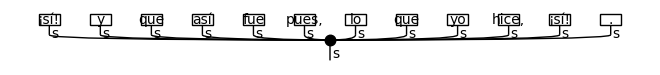

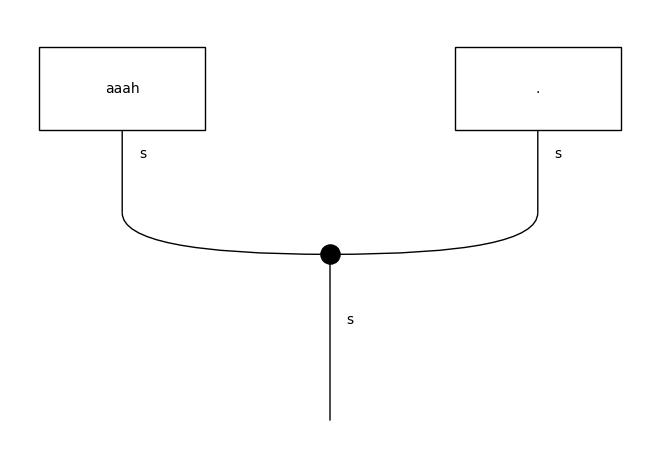

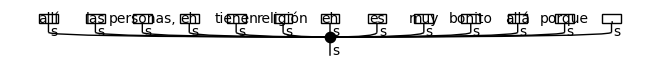

In [ ]:
#print and assert statements for debugging
assert len(train_diagrams)== len(train_labels_v2)
print(len(train_diagrams), len(test_diagrams), len(val_diagrams))
assert len(train_diagrams)== len(train_labels)
assert len(val_diagrams)== len(val_labels)
assert len(test_diagrams)== len(test_labels)
train_diagrams[0].draw()
val_diagrams[0].draw()
test_diagrams[0].draw()


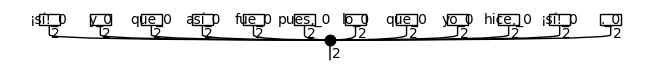

In [ ]:
from lambeq.backend.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2),
                       AtomicType.PREPOSITIONAL_PHRASE: Dim(2),
                       })

train_circuits =  [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

## Setting up the model and training requirements

In [ ]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [ ]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

In [ ]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

In [ ]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

81 81
81 11 11


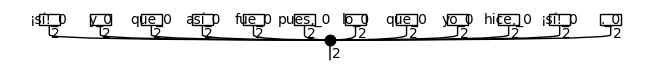

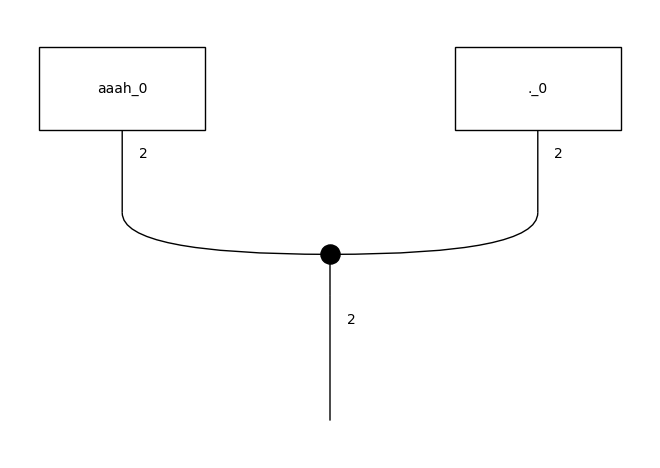

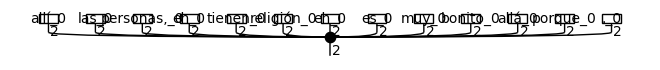

In [ ]:
print(len(train_labels), len(train_circuits))
#print and assert statements for debugging
print(len(train_circuits), len(val_circuits), len(test_circuits))
assert len(train_circuits)== len(train_labels)
assert len(val_circuits)== len(val_labels)
assert len(test_circuits)== len(test_labels)
train_circuits[0].draw()
val_circuits[0].draw()
test_circuits[0].draw()


## Training the model

In [ ]:
trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 0.6773   valid/loss: 0.7128   train/acc: 0.7099   valid/acc: 0.5000
Epoch 10:  train/loss: 0.5354   valid/loss: 0.6975   train/acc: 0.8272   valid/acc: 0.5000
Epoch 15:  train/loss: 0.1816   valid/loss: 2.9799   train/acc: 0.9383   valid/acc: 0.5455
Epoch 20:  train/loss: 0.0330   valid/loss: 15.5131   train/acc: 0.9877   valid/acc: 0.5000
Epoch 25:  train/loss: 0.0003   valid/loss: 32.6689   train/acc: 0.9877   valid/acc: 0.5000
Epoch 30:  train/loss: 0.0000   valid/loss: 32.8617   train/acc: 0.9877   valid/acc: 0.5000

Training completed!


Test accuracy: 0.4545454680919647


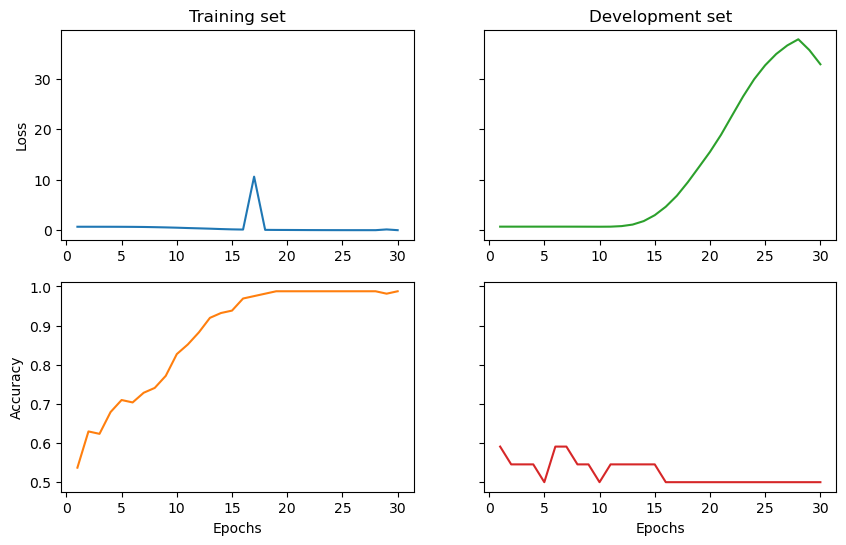

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

In [ ]:
class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds.float())
        return preds

In [ ]:
custom_model = MyCustomModel.from_diagrams(all_circuits)
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

custom_model_trainer.fit(train_dataset, val_dataset, log_interval=5)

Epoch 5:   train/loss: 0.5691   valid/loss: 0.6678   train/acc: 0.6790   valid/acc: 0.7273
Epoch 10:  train/loss: 0.4460   valid/loss: 0.9582   train/acc: 0.7593   valid/acc: 0.6364
Epoch 15:  train/loss: 0.2121   valid/loss: 2.9189   train/acc: 0.9012   valid/acc: 0.3182
Epoch 20:  train/loss: 0.0004   valid/loss: 6.9012   train/acc: 1.0000   valid/acc: 0.5455
Epoch 25:  train/loss: 0.7094   valid/loss: 9.5633   train/acc: 0.9877   valid/acc: 0.5455
Epoch 30:  train/loss: 0.0000   valid/loss: 10.9060   train/acc: 1.0000   valid/acc: 0.4545

Training completed!


Test accuracy: 0.4545454680919647


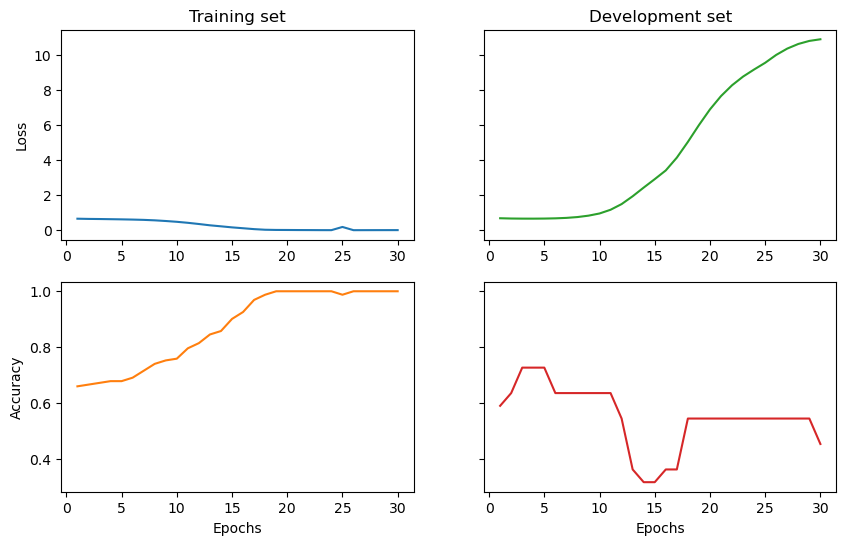

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, custom_model_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, custom_model_trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, custom_model_trainer.val_costs, color=next(colours))
ax_br.plot(range_, custom_model_trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())